In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
data = pd.read_csv("/home/strongich/PythonProj/UNI/MSC/IDA/lab1/cleared_data.csv")
data = data.sample(n=10000)
data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,satisfaction
16414,-2.512972,-2.674347,-0.020669,-0.534072,-0.897992,0.946923,-0.176800,0.080268,-0.277677,0.505562,0.143302,-0.316528,0.010204,0.165339,1
79910,2.823919,-3.421928,0.574096,-0.917956,-1.186165,0.201706,-2.523284,-0.766589,0.894684,-0.975332,-0.222024,0.301682,-1.144088,0.227945,1
91943,-1.797170,-1.422809,0.077398,-0.269801,-0.738087,-0.296839,0.388778,-0.101855,0.146317,0.099075,0.104388,-0.868828,0.021881,-0.099807,1
12630,-3.207014,-2.297170,-1.341667,-0.333866,0.393946,-0.140221,0.466145,0.399882,-0.250959,0.170755,0.220745,0.326774,-0.059886,-0.231294,1
42847,-1.588695,2.931488,-1.929694,-0.181589,-1.861927,-0.637991,0.316026,1.006966,0.097687,-0.026217,0.059493,-0.987551,0.069892,0.362866,1


Epoch [10/50], Train Loss: 0.3116, Val Loss: 0.3077
Epoch [20/50], Train Loss: 0.2755, Val Loss: 0.2749
Epoch [30/50], Train Loss: 0.2502, Val Loss: 0.2562
Epoch [40/50], Train Loss: 0.2392, Val Loss: 0.2492
Epoch [50/50], Train Loss: 0.2326, Val Loss: 0.2436


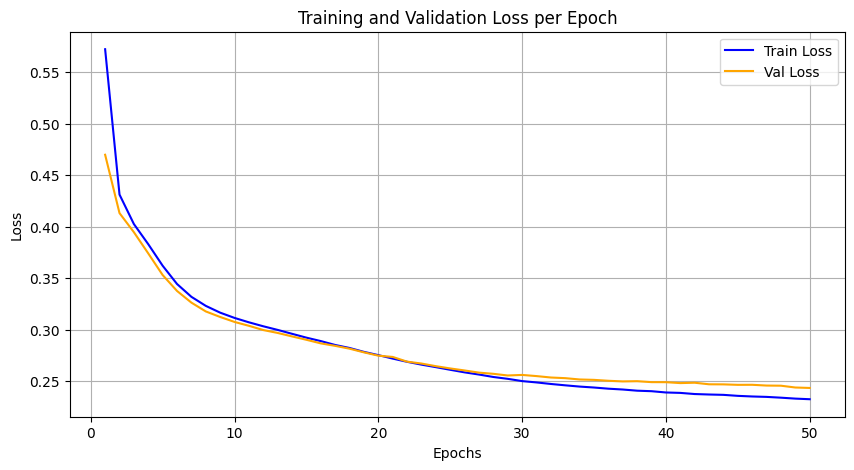


Classification Report:
               precision    recall  f1-score   support

Not Satisfied       0.90      0.91      0.90      1113
    Satisfied       0.89      0.87      0.88       887

     accuracy                           0.89      2000
    macro avg       0.89      0.89      0.89      2000
 weighted avg       0.89      0.89      0.89      2000



In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(14, 10)  # Input layer to hidden layer
        self.fc2 = nn.Linear(10, 1)  # Hidden layer to output layer
        self.sigmoid = nn.Sigmoid()  # Activation function for binary output

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation for hidden layer
        x = self.sigmoid(self.fc2(x))  # Activation for output layer
        return x


# Assuming `data` is your DataFrame containing the features and the "satisfaction" column
# Split the dataset into training and testing sets
train, test = train_test_split(data, random_state=42, train_size=0.8)

# Create Tensor datasets
train_dataset = TensorDataset(
    torch.Tensor(train.drop("satisfaction", axis=1).values),
    torch.Tensor(train["satisfaction"].values),
)
test_dataset = TensorDataset(
    torch.Tensor(test.drop("satisfaction", axis=1).values),
    torch.Tensor(test["satisfaction"].values),
)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the neural network, optimizer, and loss function
model = SimpleNN().to(device)  # Move the model to GPU
criterion = nn.BCELoss()  # Binary Cross Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

# Training and validation loop
num_epochs = 50
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    epoch_train_loss = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels.view(-1, 1))  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        epoch_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss

    # Average training loss for this epoch
    avg_train_loss = epoch_train_loss / len(train_dataloader.dataset)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    epoch_val_loss = 0
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():  # Disable gradient calculation for validation
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(
                device
            )  # Move data to GPU
            val_outputs = model(val_inputs)  # Forward pass
            val_loss = criterion(
                val_outputs, val_labels.view(-1, 1)
            )  # Calculate validation loss
            epoch_val_loss += val_loss.item() * val_inputs.size(
                0
            )  # Accumulate validation loss

            # Store true labels and predicted labels
            val_true_labels.extend(
                val_labels.cpu().numpy()
            )  # Move to CPU and convert to numpy
            val_predictions.extend(
                (val_outputs.cpu().numpy() > 0.5).astype(int)
            )  # Threshold to get binary predictions

    # Average validation loss for this epoch
    avg_val_loss = epoch_val_loss / len(val_dataloader.dataset)
    val_losses.append(avg_val_loss)
    if (epoch + 1 )% 10 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
        )

# Plotting Train Loss and Val Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss", color="orange")
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Classification report
print("\nClassification Report:")
print(
    classification_report(
        val_true_labels, val_predictions, target_names=["Not Satisfied", "Satisfied"]
    )
)

Epoch [10/50], Train Loss: 0.2394, Val Loss: 0.4905
Epoch [20/50], Train Loss: 0.1444, Val Loss: 0.5076
Epoch [30/50], Train Loss: 0.1180, Val Loss: 0.5083
Epoch [40/50], Train Loss: 0.1146, Val Loss: 0.4849
Epoch [50/50], Train Loss: 0.1043, Val Loss: 0.6930


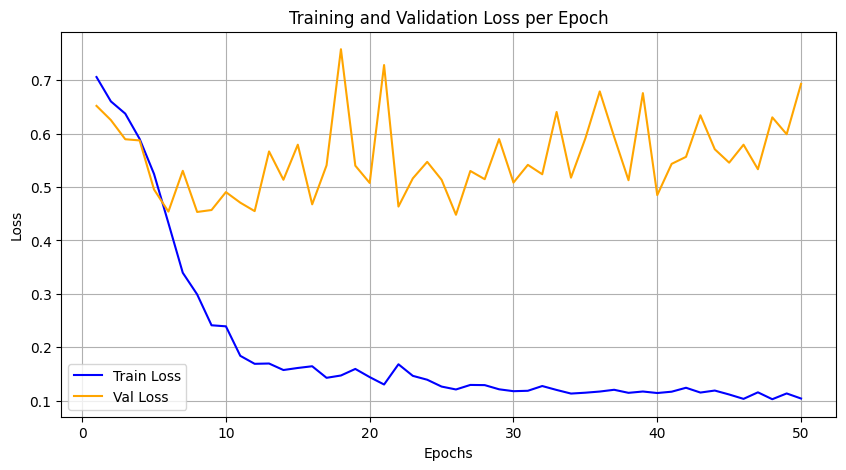


Classification Report:
              precision    recall  f1-score   support

     African       0.93      0.56      0.70        97
       Asian       0.67      0.96      0.79        91

    accuracy                           0.75       188
   macro avg       0.80      0.76      0.74       188
weighted avg       0.80      0.75      0.74       188



In [25]:
# dataset - https://www.kaggle.com/datasets/vivmankar/asian-vs-african-elephant-image-classification
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformations
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
        transforms.ToTensor(),  # Convert images to tensor
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        ),  # Normalize images
    ]
)

# Load datasets
train_dataset = datasets.ImageFolder(root="dataset/train", transform=transform)
test_dataset = datasets.ImageFolder(root="dataset/test", transform=transform)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            3, 16, kernel_size=3, padding=1
        )  # Input: 3 channels (RGB)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Output: 32 channels
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 1)  # Output layer for binary classification

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv + ReLU + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv + ReLU + pooling
        x = x.view(-1, 32 * 32 * 32)  # Flatten the output
        x = torch.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer (no sigmoid here)
        return x


# Initialize the model, optimizer, and loss function
model = SimpleCNN().to(device)  # Move the model to GPU
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss with logits
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    epoch_train_loss = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device).float()  # Convert labels to float and move to GPU
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass

        # Calculate loss
        loss = criterion(outputs, labels.view(-1, 1))  # Ensure labels are the correct shape

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        epoch_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss

    # Average training loss for this epoch
    avg_train_loss = epoch_train_loss / len(train_dataloader.dataset)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    epoch_val_loss = 0
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():  # Disable gradient calculation for validation
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device).float()  # Convert to float
            val_outputs = model(val_inputs)  # Forward pass
            val_loss = criterion(val_outputs, val_labels.view(-1, 1))  # Calculate validation loss
            epoch_val_loss += val_loss.item() * val_inputs.size(0)  # Accumulate validation loss

            # Store true labels and predicted labels
            val_true_labels.extend(val_labels.cpu().numpy())  # Move to CPU and convert to numpy
            val_predictions.extend((torch.sigmoid(val_outputs).cpu().numpy() > 0.5).astype(int))  # Threshold to get binary predictions

    # Average validation loss for this epoch
    avg_val_loss = epoch_val_loss / len(val_dataloader.dataset)
    val_losses.append(avg_val_loss)

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plotting Train Loss and Val Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss", color="orange")
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(val_true_labels, val_predictions, target_names=train_dataset.classes))


Epoch [10/50], Train Loss: 0.2240, Val Loss: 0.4759
Epoch [20/50], Train Loss: 0.1577, Val Loss: 0.3524
Epoch [30/50], Train Loss: 0.1644, Val Loss: 0.7571
Epoch [40/50], Train Loss: 0.1562, Val Loss: 0.6302
Epoch [50/50], Train Loss: 0.1515, Val Loss: 0.4133


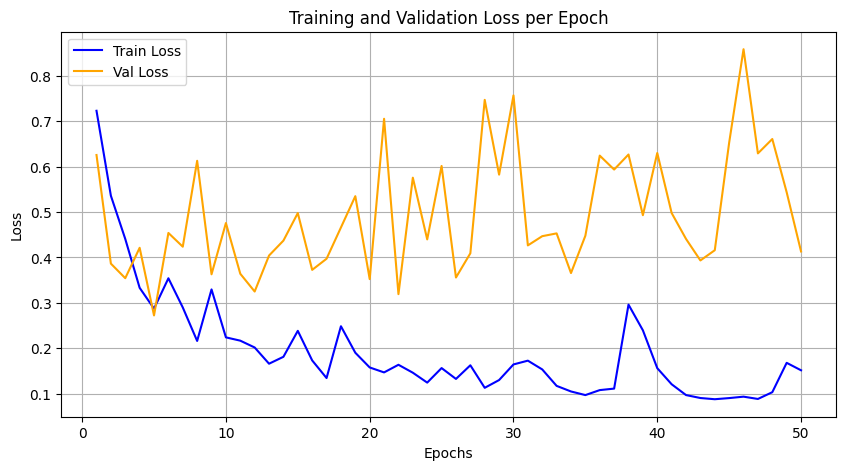


Classification Report:
              precision    recall  f1-score   support

     African       0.93      0.69      0.79        97
       Asian       0.74      0.95      0.83        91

    accuracy                           0.81       188
   macro avg       0.84      0.82      0.81       188
weighted avg       0.84      0.81      0.81       188



In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformations
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Resize images to 224x224 pixels for MobileNet
        transforms.ToTensor(),  # Convert images to tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalize for MobileNet
    ]
)

# Load datasets
train_dataset = datasets.ImageFolder(root="dataset/train", transform=transform)
test_dataset = datasets.ImageFolder(root="dataset/test", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load pretrained MobileNet model
model = models.mobilenet_v2(pretrained=True)

# Modify the final layer to fit our binary classification problem
num_classes = 1  # Number of classes
model.classifier[1] = nn.Linear(
    model.last_channel, num_classes
)  # Update the classifier to output two classes


# Use sigmoid activation for binary classification
def forward_pass_with_sigmoid(x):
    return torch.sigmoid(x)


model.to(device)  # Move the model to GPU
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss with logits
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    epoch_train_loss = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device).float()  # Convert labels to float and move to GPU
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass

        # Calculate loss
        loss = criterion(outputs, labels.view(-1, 1))  # Ensure labels are the correct shape

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        epoch_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss

    # Average training loss for this epoch
    avg_train_loss = epoch_train_loss / len(train_dataloader.dataset)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    epoch_val_loss = 0
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():  # Disable gradient calculation for validation
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device).float()  # Convert to float
            val_outputs = model(val_inputs)  # Forward pass
            val_loss = criterion(val_outputs, val_labels.view(-1, 1))  # Calculate validation loss
            epoch_val_loss += val_loss.item() * val_inputs.size(0)  # Accumulate validation loss

            # Store true labels and predicted labels
            val_true_labels.extend(val_labels.cpu().numpy())  # Move to CPU and convert to numpy
            val_predictions.extend((torch.sigmoid(val_outputs).cpu().numpy() > 0.5).astype(int))  # Threshold to get binary predictions

    # Average validation loss for this epoch
    avg_val_loss = epoch_val_loss / len(val_dataloader.dataset)
    val_losses.append(avg_val_loss)

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plotting Train Loss and Val Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss", color="orange")
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(val_true_labels, val_predictions, target_names=train_dataset.classes))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import numpy as np


In [8]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/home/strongich/PythonProj/UNI/MSC/IDA/lab2/nltdata.csv")

# Encode classs
class_encoder = LabelEncoder()
df["class"] = class_encoder.fit_transform(df["class"])

# Tokenize and create vocabulary
from collections import Counter


# Tokenization function
def tokenize(text):
    return text.split()


# Create vocabulary
all_words = [word for text in df["text"] for word in tokenize(text)]
word_counts = Counter(all_words)
vocab = {
    word: i + 1 for i, (word, _) in enumerate(word_counts.most_common())
}  # Start index from 1
vocab_size = len(vocab) + 1  # +1 for padding
print(vocab_size)


# Function to convert text to sequences
def text_to_sequence(text):
    return [vocab[word] for word in tokenize(text) if word in vocab]


# Convert text to sequences
df["text_seq"] = df["text"].apply(text_to_sequence)

# Padding sequences
from torch.nn.utils.rnn import pad_sequence


def pad_sequences(sequences, max_length):
    return pad_sequence(
        [torch.tensor(seq[:max_length]) for seq in sequences], batch_first=True
    )


max_length = 50  # Define maximum length of sequences
X = pad_sequences(df["text_seq"].tolist(), max_length)
y = torch.tensor(df["class"].values)

172429


In [11]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create datasets and dataloaders
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Get the output of the last time step
        x = self.fc(x)
        return x


from sklearn.metrics import classification_report

# Initialize model, loss function, and optimizer
model = RNNClassifier(
    vocab_size, embedding_dim=100, hidden_dim=64, output_dim=len(class_encoder.classes_)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Evaluation on the test set after each epoch
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

Epoch [1/10], Loss: 0.5128
Epoch [2/10], Loss: 0.4284
Epoch [3/10], Loss: 0.6544
Epoch [4/10], Loss: 0.5180
Epoch [5/10], Loss: 0.4446
Epoch [6/10], Loss: 0.3055
Epoch [7/10], Loss: 0.4667
Epoch [8/10], Loss: 0.3388
Epoch [9/10], Loss: 0.1714
Epoch [10/10], Loss: 0.2254

Classification Report:


TypeError: object of type 'numpy.int64' has no len()

In [17]:
# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.57      0.58      2290
           1       0.87      0.89      0.88      7710

    accuracy                           0.81     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.81      0.81      0.81     10000



In [21]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_peak_memory_stats()

/home/strongich/miniconda3/envs/main/lib/python3.11/site-packages/torch/cuda/memory.py:329: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [28]:
import numpy as np


# Load GloVe embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    return embeddings_index


# Example usage
glove_file = "/home/strongich/PythonProj/UNI/MSC/IDA/lab3/glove.6B.200d.txt"  # Specify the path to your GloVe file
embeddings_index = load_glove_embeddings(glove_file)

In [29]:
from torch.nn import functional as F


def create_embedding_matrix(vocab, embeddings_index, embedding_dim):
    # Create a matrix for embeddings
    embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))  # +1 for padding
    for word, i in vocab.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return torch.tensor(embedding_matrix, dtype=torch.float32)


# Example usage
embedding_dim = (
    200  # Make sure this matches the dimension of the GloVe vectors you are using
)
embedding_matrix = create_embedding_matrix(vocab, embeddings_index, embedding_dim)


class RNNClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=True
        )  # Set freeze to True or False based on your choice
        self.rnn = nn.RNN(embedding_matrix.size(1), hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Get the output of the last time step
        x = self.fc(x)
        return x


# Initialize model, loss function, and optimizer
model = RNNClassifier(
    embedding_matrix=embedding_matrix,
    hidden_dim=64,
    output_dim=len(class_encoder.classes_),
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00007)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Evaluation on the test set after each epoch
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

Epoch [1/10], Loss: 0.4337
Epoch [2/10], Loss: 0.3681
Epoch [3/10], Loss: 0.3378
Epoch [4/10], Loss: 0.2380
Epoch [5/10], Loss: 0.4733
Epoch [6/10], Loss: 0.4293
Epoch [7/10], Loss: 0.3573
Epoch [8/10], Loss: 0.3197
Epoch [9/10], Loss: 0.2145
Epoch [10/10], Loss: 0.2867
              precision    recall  f1-score   support

           0       0.67      0.53      0.59      2290
           1       0.87      0.92      0.90      7710

    accuracy                           0.83     10000
   macro avg       0.77      0.73      0.74     10000
weighted avg       0.82      0.83      0.83     10000

